In [1]:
import sys
sys.path.append('..')
from custom_lib import lib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset
from sklearn.neural_network import MLPRegressor
import gmdh
import itertools
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
sns.set(style="ticks")

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
data = pd.read_csv('laptop_price.csv', sep=',')

In [4]:
data.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [5]:
data.drop(columns=['laptop_ID', 'Product'], inplace=True)

In [6]:
data = data.join(pd.get_dummies(data.Company))
data = data.drop("Company", axis=1)

In [7]:
data = data.join(pd.get_dummies(data.TypeName))
data = data.drop("TypeName", axis=1)

In [8]:
# list[-1] == last element
data["ScreenResolution"] = data["ScreenResolution"].str.split(" ").apply(lambda x: x[-1])
data["ScreenResolution"].head(2)

0    2560x1600
1     1440x900
Name: ScreenResolution, dtype: object

In [9]:
data["Screen Width"] = data.ScreenResolution.str.split("x").apply(lambda x: x[0])
data["Screen Height"] = data.ScreenResolution.str.split("x").apply(lambda x: x[1])
data[["Screen Width", "Screen Height"]].head(2)

,Screen Width,Screen Height
0,2560,1600
1,1440,900


In [10]:
data = data.drop('ScreenResolution', axis=1)

In [11]:
# re try out --> hell
data["CPU Frequency"] = data["Cpu"].apply(lambda x: re.findall(r'(\d(?:\.\d)?)(?=GHz)', x)[0])

In [12]:
data["CPU Brand"] = data.Cpu.str.split(" ").apply(lambda x: x[0])

In [13]:
data = data.drop("Cpu", axis=1)

In [14]:
data["Ram"] = data["Ram"].str[:-2]
data["Ram"] = data["Ram"].astype("int")
data["CPU Frequency"] = data["CPU Frequency"].astype("float")

In [15]:
data["Weight"] = data["Weight"].str[:-2]
data["Weight"] = data["Weight"].astype("float")

In [16]:
data["GPU Brand"] = data.Gpu.str.split(" ").apply(lambda x: x[0])

In [17]:
data = data.drop("Gpu", axis=1)

In [18]:
data = data.join(pd.get_dummies(data.OpSys))
data = data.drop("OpSys", axis=1)

In [19]:
cpu_categories = pd.get_dummies(data["CPU Brand"])
cpu_categories.columns = [col + "_CPU" for col in cpu_categories.columns]

data = data.join(cpu_categories)
data = data.drop("CPU Brand", axis=1)

In [20]:
gpu_categories = pd.get_dummies(data["GPU Brand"])
gpu_categories.columns = [col + "GPU" for col in gpu_categories.columns]

data = data.join(gpu_categories)
data = data.drop("GPU Brand", axis=1)

In [21]:
data["Memory"].head(22)

0                128GB SSD
1      128GB Flash Storage
2                256GB SSD
3                512GB SSD
4                256GB SSD
5                500GB HDD
6      256GB Flash Storage
7      256GB Flash Storage
8                512GB SSD
9                256GB SSD
10               500GB HDD
11               500GB HDD
12               256GB SSD
13               256GB SSD
14               256GB SSD
15               256GB SSD
16               256GB SSD
17               512GB SSD
18                 1TB HDD
19               128GB SSD
20      32GB Flash Storage
21    128GB SSD +  1TB HDD
Name: Memory, dtype: object

In [22]:
data['SSD'] = 0
data['HDD'] = 0
data['Flash'] = 0
data['Hybrid'] = 0

def convert_to_mb(memory_str):
    pattern = r"(\d+)([A-Za-z]+)"
    memory_values = re.findall(pattern, memory_str)
    mb = 0
    value = int(memory_values[0][0])
    unit = memory_values[0][1]
    if unit == 'GB':
        mb += value * 1000
    elif unit == 'TB':
        mb += value * 1000 * 1000
    return mb

for index, row in data.iterrows():
    memory_values = row['Memory'].split('+')
    for value in memory_values:
        value = value.strip()
        if 'SSD' in value:
            data.at[index, 'SSD'] = convert_to_mb(value)
        elif 'HDD' in value:
            data.at[index, 'HDD'] = convert_to_mb(value)
        elif 'Flash' in value:
            data.at[index, 'Flash'] = convert_to_mb(value)
        elif 'Hybrid' in value:
            data.at[index, 'Hybrid'] = convert_to_mb(value)

data[["SSD", "HDD", "Flash", "Hybrid"]].head(22)

,SSD,HDD,Flash,Hybrid
0,128000,0,0,0
1,0,0,128000,0
2,256000,0,0,0
3,512000,0,0,0
4,256000,0,0,0
5,0,500000,0,0
6,0,0,256000,0
7,0,0,256000,0
8,512000,0,0,0
9,256000,0,0,0


In [23]:
data = data.drop("Memory", axis=1)

In [24]:
data = data.drop_duplicates()

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1274 entries, 0 to 1273
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Inches              1274 non-null   float64
 1   Ram                 1274 non-null   int32  
 2   Weight              1274 non-null   float64
 3   Price_euros         1274 non-null   float64
 4   Acer                1274 non-null   bool   
 5   Apple               1274 non-null   bool   
 6   Asus                1274 non-null   bool   
 7   Chuwi               1274 non-null   bool   
 8   Dell                1274 non-null   bool   
 9   Fujitsu             1274 non-null   bool   
 10  Google              1274 non-null   bool   
 11  HP                  1274 non-null   bool   
 12  Huawei              1274 non-null   bool   
 13  LG                  1274 non-null   bool   
 14  Lenovo              1274 non-null   bool   
 15  MSI                 1274 non-null   bool   
 16  Mediacom   

In [26]:
data.head()

,Inches,Ram,Weight,Price_euros,Acer,Apple,Asus,Chuwi,Dell,Fujitsu,Google,HP,Huawei,LG,Lenovo,MSI,Mediacom,Microsoft,Razer,Samsung,Toshiba,Vero,Xiaomi,2 in 1 Convertible,Gaming,Netbook,Notebook,Ultrabook,Workstation,Screen Width,Screen Height,CPU Frequency,Android,Chrome OS,Linux,Mac OS X,No OS,Windows 10,Windows 10 S,Windows 7,macOS,AMD_CPU,Intel_CPU,Samsung_CPU,AMDGPU,ARMGPU,IntelGPU,NvidiaGPU,SSD,HDD,Flash,Hybrid
0,13.3,8,1.37,1339.69,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,2560,1600,2.3,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,128000,0,0,0
1,13.3,8,1.34,898.94,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1440,900,1.8,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,0,0,128000,0
2,15.6,8,1.86,575.00,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,1920,1080,2.5,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,256000,0,0,0
3,15.4,16,1.83,2537.45,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,2880,1800,2.7,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,512000,0,0,0
4,13.3,8,1.37,1803.60,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,2560,1600,3.1,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,256000,0,0,0


array([[<Axes: title={'center': 'Inches'}>,
        <Axes: title={'center': 'Ram'}>,
        <Axes: title={'center': 'Weight'}>],
       [<Axes: title={'center': 'Price_euros'}>,
        <Axes: title={'center': 'CPU Frequency'}>,
        <Axes: title={'center': 'SSD'}>],
       [<Axes: title={'center': 'HDD'}>,
        <Axes: title={'center': 'Flash'}>,
        <Axes: title={'center': 'Hybrid'}>]], dtype=object)

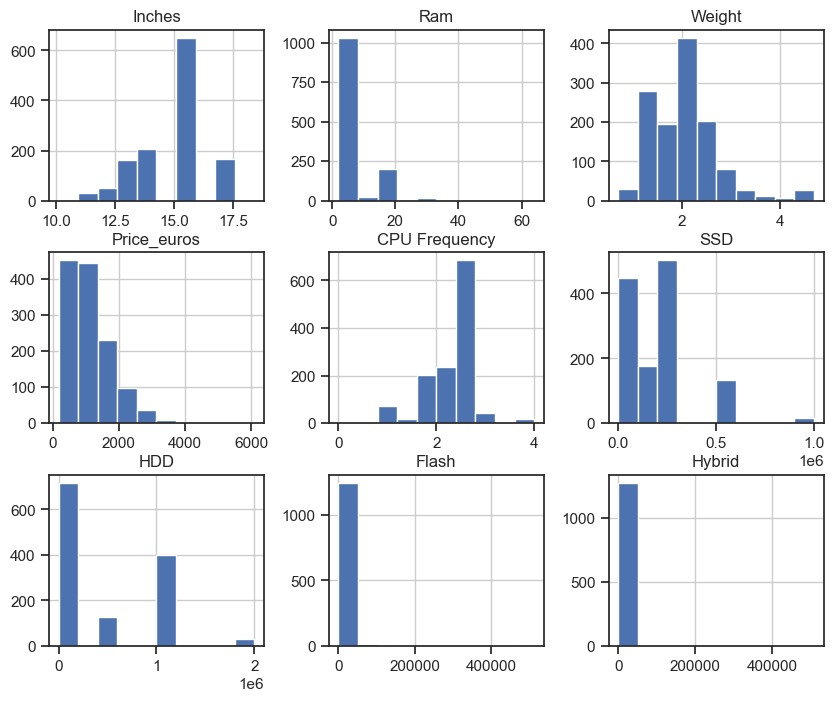

In [27]:
data.hist(figsize=(10,8))

### Обычные модели

In [28]:
data_X = data.drop(columns='Price_euros', axis=1)
data_y = data['Price_euros']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=1)

In [30]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=50)
]:
    lib.test_model(model, X_test_scaled, y_test, X_train_scaled, y_train)

LinearRegression()
mean_absolute_error: 239.28172467700944
median_absolute_error: 170.05664878805032
r2_score: 0.7500544429668967
---------------------------------------
DecisionTreeRegressor()
mean_absolute_error: 243.39075816993463
median_absolute_error: 140.9699999999998
r2_score: 0.6826685552585303
---------------------------------------
RandomForestRegressor(n_estimators=50)
mean_absolute_error: 201.69014179178342
median_absolute_error: 117.72853333333342
r2_score: 0.8021922005286598
---------------------------------------


### Стекинг

In [32]:
# Используем библиотеку heamy
# набор данных
dataset = Dataset(X_train_scaled, y_train, X_test_scaled)

In [33]:
# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')

# parameters={'normalize': True} error
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, 
                      name='lr')

model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, 
                     parameters={'n_estimators': 50}, name='rf')

model_svr = Regressor(dataset=dataset, estimator=SVR, name='svr', parameters={'kernel':'linear'})

In [34]:
# 1
# 1: tree + lr
# 2: lr

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)

stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10, scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [258.7732326742601, 215.0907880918148, 290.5932982978107, 242.3372373505647, 236.93146080792383, 279.86926635779207, 228.3636138407287, 264.4121162141062, 211.063877109822, 282.87463597798]
Mean accuracy: 251.03095267228028
Standard Deviation: 27.06860413315101
Variance: 732.7093297172398


In [35]:
# 2
# 1: lr + svm
# 2: lr

pipeline = ModelsPipeline(model_lr, model_svr)
stack_ds = pipeline.stack(k=10, seed=1)

stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10, scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [277.0729954506853, 256.1540149345636, 285.0062915308119, 200.52090016554158, 261.1828370255923, 261.7365075251813, 224.98709773879355, 252.52086316444172, 199.2860894433298, 249.16329164407557]
Mean accuracy: 246.76308886230163
Standard Deviation: 27.941129362997337
Variance: 780.7067100797519


In [36]:
# 3
# 1: tree + lr + svr
# 2: lr

pipeline = ModelsPipeline(model_tree, model_lr, model_svr)
stack_ds = pipeline.stack(k=10, seed=1)

stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10, scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [239.3353886998449, 212.75655442345555, 258.0721877575672, 181.76843229079893, 222.7357709800095, 224.21508208229434, 199.40344888089604, 223.46001927916097, 169.96953882692165, 239.84528826411906]
Mean accuracy: 217.15617114850684
Standard Deviation: 25.719484651691076
Variance: 661.4918907485728


In [37]:
# 4
# 1: tree + lr + svr
# 2: rf

pipeline = ModelsPipeline(model_tree, model_lr, model_svr)
stack_ds = pipeline.stack(k=10, seed=1)

stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10, scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [274.4436434477125, 214.73761568627452, 276.98297950513535, 179.1062009803922, 259.9473879901961, 225.63257785947715, 197.98219885620918, 223.749889379085, 197.69020579248368, 243.43489250353602]
Mean accuracy: 229.37075920005017
Standard Deviation: 31.94736382644386
Variance: 1020.6340554591736


In [38]:
# 5
# 1: tree + lr + rf
# 2: lr

pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)

stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10, scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [200.59286612357428, 180.9454161109257, 213.46502324164118, 188.74938041962702, 194.5664305264433, 222.79665036112456, 191.9506535499393, 189.99561614040445, 144.11742000919304, 216.65737586003118]
Mean accuracy: 194.38368323429037
Standard Deviation: 21.143091887669623
Variance: 447.030334570441


In [39]:
df_y = pd.DataFrame(data_y)
df_y.describe()

,Price_euros
count,1274.000000
mean,1135.570290
std,700.698629
min,174.000000
25%,609.902500
50%,989.000000
75%,1497.250000
max,6099.000000


### Многослойный персептрон

In [40]:
mlp_reg = MLPRegressor(random_state=1)
mlp_reg.fit(X_train_scaled, y_train)

MLPRegressor(random_state=1)

In [41]:
lib.test_model(mlp_reg, X_test_scaled, y_test)

MLPRegressor(random_state=1)
mean_absolute_error: 441.04968062933233
median_absolute_error: 393.14173790047425
r2_score: 0.38742122801752266
---------------------------------------


In [42]:
# param_grid = {
#     'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 25, 50, 100],
#     'max_iter': [10, 100, 200, 500, 1000, 2000],
#     'hidden_layer_sizes': [100,250,500] + list(itertools.permutations([100,250,500],2)) 
#     + list(itertools.permutations([100,250,500],3)),
# }

# mlp = MLPRegressor(random_state=1)

# grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, 
#                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# grid_search.fit(X_train_scaled, y_train)

# best_mlp = grid_search.best_estimator_
# train_mae = mean_absolute_error(y_train, best_mlp.predict(X_train_scaled))
# test_mae = mean_absolute_error(y_test, best_mlp.predict(X_test_scaled))

# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Train MAE: {train_mae}")
# print(f"Test MAE: {test_mae}")

In [43]:
# grid_search.best_params_['alpha'] = 50
# max_iter=grid_search.best_params_['max_iter'] = 500
mlp_reg_tuned = MLPRegressor(hidden_layer_sizes=(250, 500), alpha=50, 
                             max_iter=500, verbose=False)

lib.test_model(mlp_reg_tuned, X_test_scaled, y_test, X_train_scaled, y_train)

MLPRegressor(alpha=50, hidden_layer_sizes=(250, 500), max_iter=500)
mean_absolute_error: 207.8810822399651
median_absolute_error: 133.15066296536952
r2_score: 0.8175711740532523
---------------------------------------


In [45]:
print("Train Score", mlp_reg_tuned.score(X_train_scaled, y_train))
print("Test Score", mlp_reg_tuned.score(X_test_scaled, y_test))

Train Score 0.9234362161733836
Test Score 0.8175711740532523


### МГУА

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_metrics(y_test, y_pred, squared=False):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    crit_name = "MSE" if squared else "RMSE"
    print(f"{crit_name}: {mean_squared_error(y_test, y_pred, squared=squared)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

def show_metric_for(y_pred, n=365):
  print_metrics(scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()[:n], y_pred[:n])

In [61]:
import gmdh
gmdh_combi = gmdh.Combi()
gmdh_combi.fit(X_train_scaled, y_train, verbose=1, n_jobs=-1, test_size=0.2, limit=0, 
                       criterion=gmdh.Criterion(gmdh.CriterionType.REGULARITY))

LEVEL 1  [=========================] 100% :00s] (51 combinations) error=5.36274e+07                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [47]:
gmdh_mia = gmdh.Mia()
gmdh_mia.fit(X_train_scaled, y_train, verbose=1, n_jobs=-1, test_size=0.2, limit=0, k_best=9, 
                     criterion=gmdh.Criterion(gmdh.CriterionType.SYM_REGULARITY), 
                     polynomial_type=gmdh.PolynomialType.LINEAR)

LEVEL 1  [>                        ] 0% :00s] (1275 combinations)

LEVEL 1  [=========================] 100% :00s] (1275 combinations) error=1.8344e+08
LEVEL 2  [=========================] 100% :00s] (36 combinations) error=1.67282e+08
LEVEL 3  [=========================] 100% :00s] (36 combinations) error=1.665e+08
LEVEL 4  [=========================] 100% :00s] (36 combinations) error=1.66383e+08
LEVEL 5  [=========================] 100% :00s] (36 combinations) error=1.66379e+08
LEVEL 6  [=========================] 100% :00s] (36 combinations) error=1.65715e+08
LEVEL 7  [=========================] 100% :00s] (36 combinations) error=1.6579e+08


In [48]:
pred_mia = gmdh_mia.predict(X_test_scaled)
print_metrics(y_test, pred_mia)

R^2: 0.5812558420729379
RMSE: 446.3090600326216
MAE: 301.6016335549532


In [49]:
gmdh_mia = gmdh.Multi()
gmdh_mia.fit(X_train_scaled, y_train, verbose=1, n_jobs=-1, test_size=0.2, limit=0, k_best=5, 
                     criterion=gmdh.Criterion(gmdh.CriterionType.SYM_REGULARITY))

LEVEL 1  [=========================] 100% :00s] (51 combinations) error=2.20473e+08
LEVEL 2  [=========================] 100% :00s] (240 combinations) error=1.8344e+08
LEVEL 3  [=========================] 100% :00s] (235 combinations) error=1.60001e+08
LEVEL 4  [=========================] 100% :00s] (234 combinations) error=1.54121e+08
LEVEL 5  [=========================] 100% :00s] (225 combinations) error=1.49158e+08
LEVEL 6  [=========================] 100% :00s] (224 combinations) error=1.44814e+08
LEVEL 7  [=========================] 100% :00s] (220 combinations) error=1.4236e+08
LEVEL 8  [=========================] 100% :00s] (214 combinations) error=1.40495e+08
LEVEL 9  [=========================] 100% :00s] (210 combinations) error=1.38546e+08
LEVEL 10 [=========================] 100% :00s] (206 combinations) error=1.37307e+08
LEVEL 11 [=========================] 100% :00s] (202 combinations) error=1.35835e+08
LEVEL 12 [=========================] 100% :00s] (197 combinations) e

In [50]:
pred_mia = gmdh_mia.predict(X_test_scaled)
print_metrics(y_test, pred_mia)

R^2: 0.764488741651164
RMSE: 334.7088217549357
MAE: 240.95189350744133


In [51]:
gmdh_ria = gmdh.Ria()
gmdh_ria.fit(X_train_scaled, y_train, verbose=1, n_jobs=-1, test_size=0.2, limit=0, k_best=7, 
                     criterion=gmdh.Criterion(gmdh.CriterionType.REGULARITY),
                     polynomial_type=gmdh.PolynomialType.LINEAR)

LEVEL 1  [>                        ] 0% :00s] (1275 combinations)

LEVEL 1  [=========================] 100% :00s] (1275 combinations) error=4.29171e+07
LEVEL 2  [=========================] 100% :00s] (357 combinations) error=3.8451e+07
LEVEL 3  [=========================] 100% :00s] (357 combinations) error=3.53379e+07
LEVEL 4  [=========================] 100% :00s] (357 combinations) error=3.31054e+07
LEVEL 5  [=========================] 100% :00s] (357 combinations) error=3.10522e+07
LEVEL 6  [=========================] 100% :00s] (357 combinations) error=2.99373e+07
LEVEL 7  [=========================] 100% :00s] (357 combinations) error=2.92871e+07
LEVEL 8  [=========================] 100% :00s] (357 combinations) error=2.82296e+07
LEVEL 9  [=========================] 100% :00s] (357 combinations) error=2.74206e+07
LEVEL 10 [=========================] 100% :00s] (357 combinations) error=2.66683e+07
LEVEL 11 [=========================] 100% :00s] (357 combinations) error=2.6317e+07
LEVEL 12 [=========================] 100% :00s] (357 combinations)

In [52]:
pred_ria = gmdh_mia.predict(X_test_scaled)
print_metrics(y_test, pred_ria)

R^2: 0.764488741651164
RMSE: 334.7088217549357
MAE: 240.95189350744133


In [65]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(8, 8)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

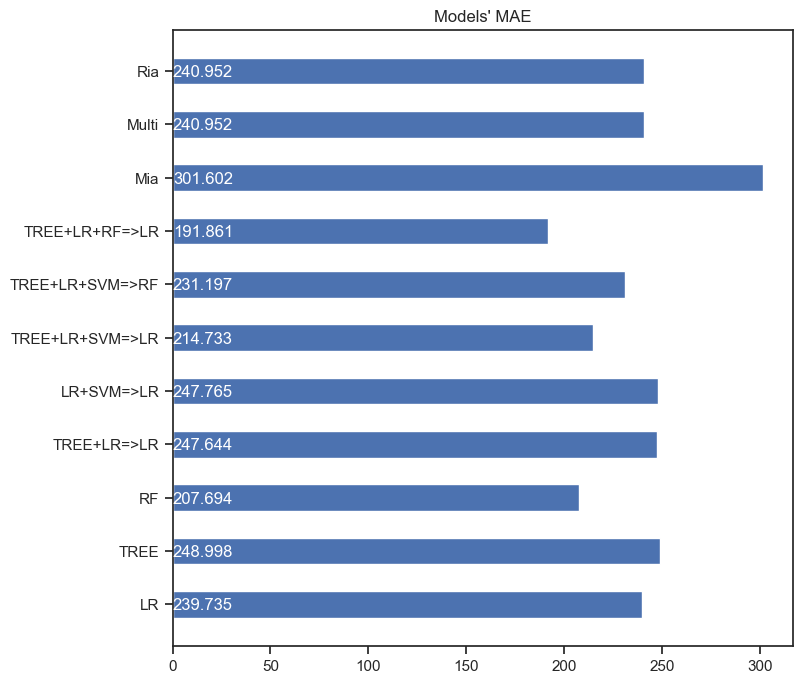

In [66]:
dict_mae = {
            'LR': 239.73464369309352,
            'TREE': 248.99816993464052,
            'RF': 207.69443431593245,
            'TREE+LR=>LR': 247.64407725178344,
            'LR+SVM=>LR': 247.76506541650429,
            'TREE+LR+SVM=>LR': 214.73276176247737,
            'TREE+LR+SVM=>RF': 231.19723895237863,
            'TREE+LR+RF=>LR': 191.86075723244494,
            'Mia': 301.6016335549532,
            'Multi': 240.95189350744133,
            'Ria': 240.95189350744133
            }
vis_models_quality(list(dict_mae.values()), list(dict_mae.keys()), 'Models\' MAE')